In [14]:
import glob
import random

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import cv2
import torch                    
import torch.nn as nn
import torchvision
from torchvision.transforms import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt

In [15]:
imdir = '/home/steiner/Escritorio/Python/pinturas/'
glob_dir = imdir + '*.jpg'

In [16]:
def get_profile_path(category):
    data = []
    for path in sorted(glob.glob(glob_dir)):
        data.append({
            'Ref_ID': path.split('/')[-1].split('/')[0],
            'path': path,
        })            
    return pd.DataFrame(data)

In [17]:
Total = get_profile_path('Total')

In [18]:
Total.head()

,Ref_ID,path
0,0_the-esquilache-riots.jpg!Large.jpg,/home/steiner/Escritorio/Python/pinturas/0_the...
1,100_they-sing-for-the-composer.jpg!Large.jpg,/home/steiner/Escritorio/Python/pinturas/100_t...
2,101_woman-battered-with-a-cane.jpg!Large.jpg,/home/steiner/Escritorio/Python/pinturas/101_w...
3,102_mariana-waldstein-ninth-marquesa-de-santa-...,/home/steiner/Escritorio/Python/pinturas/102_m...
4,103_incantation.jpg!Large.jpg,/home/steiner/Escritorio/Python/pinturas/103_i...


In [19]:
def resize_to_square(image, size):
    h, w, d = image.shape
    ratio = size / max(h, w)
    resized_image = cv2.resize(image, (int(w*ratio), int(h*ratio)), cv2.INTER_AREA)
    return resized_image

def image_to_tensor(image, normalize=None):
    tensor = torch.from_numpy(np.moveaxis(image / (255. if image.dtype == np.uint8 else 1), -1, 0).astype(np.float32))
    if normalize is not None:
        return F.normalize(tensor, **normalize)
    return tensor

def pad(image, min_height, min_width):
    h,w,d = image.shape

    if h < min_height:
        h_pad_top = int((min_height - h) / 2.0)
        h_pad_bottom = min_height - h - h_pad_top
    else:
        h_pad_top = 0
        h_pad_bottom = 0

    if w < min_width:
        w_pad_left = int((min_width - w) / 2.0)
        w_pad_right = min_width - w - w_pad_left
    else:
        w_pad_left = 0
        w_pad_right = 0

    return cv2.copyMakeBorder(image, h_pad_top, h_pad_bottom, w_pad_left, w_pad_right, cv2.BORDER_CONSTANT, value=(0,0,0))

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, size):
        self.df = df
        self.size = size
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        image = cv2.imread(row.path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = resize_to_square(image, self.size)
        image = pad(image, self.size, self.size)
        tensor = image_to_tensor(image, normalize={'mean': [0.1, 0.1, 0.1], 'std': [0.9, 0.9, 0.9]})
            
        return tensor


In [20]:
random.seed(737)

/home/steiner/Escritorio/Python/pinturas/102_mariana-waldstein-ninth-marquesa-de-santa-cruz.jpg!Large.jpg
/home/steiner/Escritorio/Python/pinturas/102_mariana-waldstein-ninth-marquesa-de-santa-cruz.jpg!Large.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


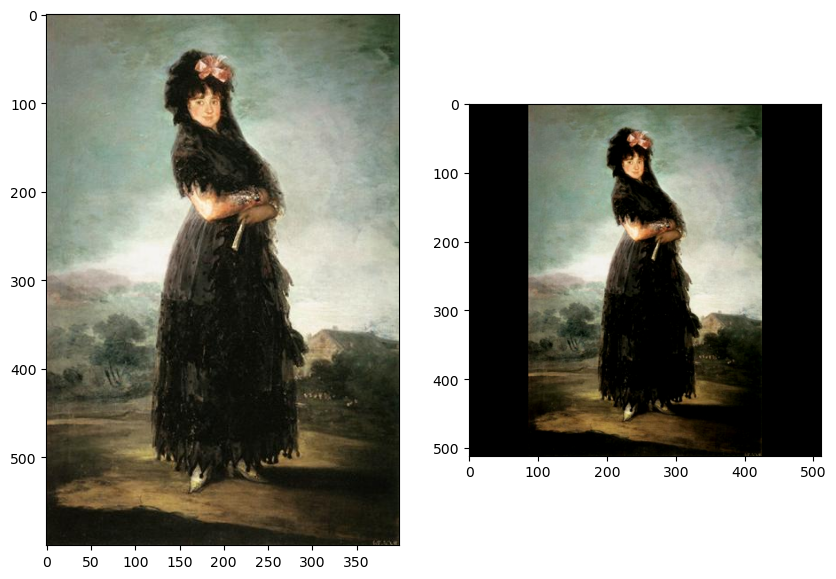

/home/steiner/Escritorio/Python/pinturas/104_the-swing.jpg!Large.jpg
/home/steiner/Escritorio/Python/pinturas/104_the-swing.jpg!Large.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


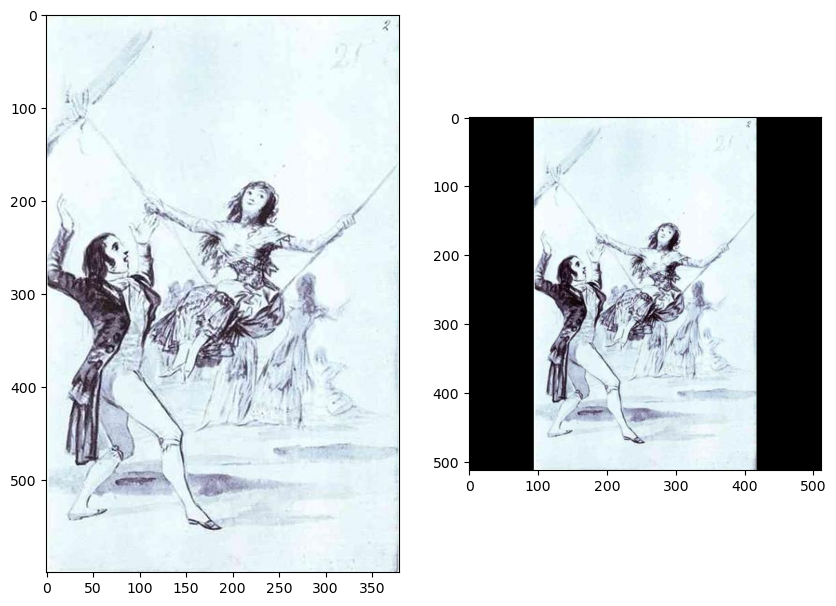

/home/steiner/Escritorio/Python/pinturas/103_incantation.jpg!Large.jpg
/home/steiner/Escritorio/Python/pinturas/103_incantation.jpg!Large.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


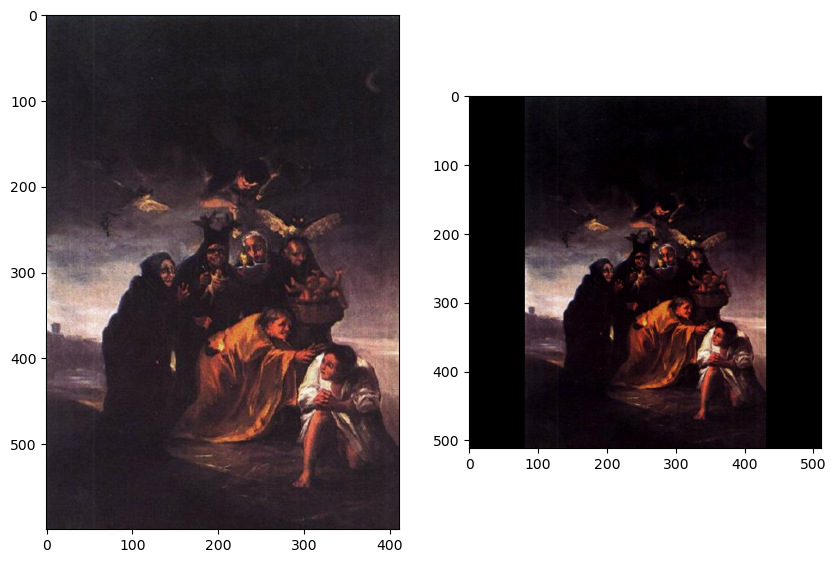

/home/steiner/Escritorio/Python/pinturas/108_don-andres-del-peral-1798.jpg!Large.jpg
/home/steiner/Escritorio/Python/pinturas/108_don-andres-del-peral-1798.jpg!Large.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


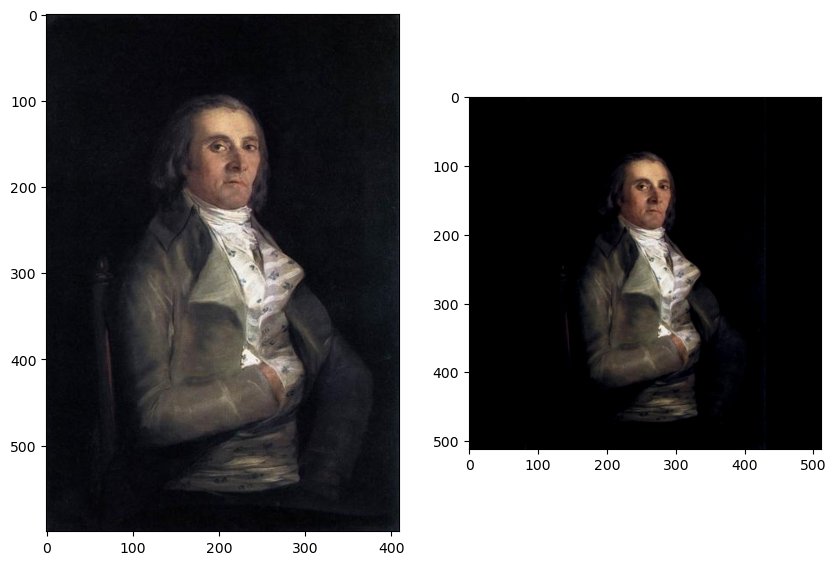

/home/steiner/Escritorio/Python/pinturas/106_francisco-de-goya-y-lucientes-the-bewitched-man-wga10039.jpg!Large.jpg
/home/steiner/Escritorio/Python/pinturas/106_francisco-de-goya-y-lucientes-the-bewitched-man-wga10039.jpg!Large.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


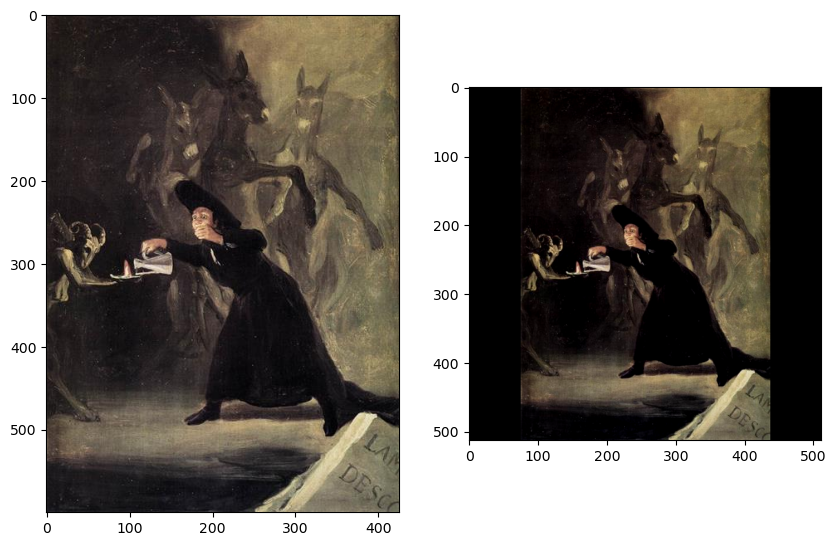

In [22]:
size = 512

def show_image_pair(image1, image2):
    fig = plt.figure(figsize=(10, 20))
    fig.add_subplot(1,2,1)
    plt.imshow(image1)
    fig.add_subplot(1,2, 2)
    plt.imshow(image2)
    plt.show()
    
def test_dataset(idx=0):

    dataset = Dataset(Total, size)

    image1 = cv2.imread(dataset.df.iloc[idx].path)
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

    tensor = dataset[idx]
    image2 = np.transpose(tensor.numpy(), (1,2,0))
    
    print(dataset.df.iloc[idx].path)
    show_image_pair(image1, image2)
    

for idx in [random.choice(range(10)) for i in range(5)]:
    print (Total.iloc[idx].path)
    test_dataset(idx)

In [23]:
model_name = 'resnet18'
layer_name = 'avgpool'

In [24]:
get_model = getattr(torchvision.models, model_name)

In [25]:
def extract_features(df):

    model = get_model(pretrained=True)
    model = model.to(device)
    model.eval()

    # register hook to access to features in forward pass
    features = []
    def hook(module, input, output):
        N,C,H,W = output.shape
        output = output.reshape(N,C,-1)
        features.append(output.mean(dim=2).cpu().detach().numpy())
    handle = model._modules.get(layer_name).register_forward_hook(hook)

    dataset = Dataset(df, size)
    loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4)

    for i_batch, inputs in tqdm(enumerate(loader), total=len(loader)):
        _ = model(inputs.to(device))

    features = np.concatenate(features)
    features = pd.DataFrame(features)
    features = features.add_prefix('IMAGE_')
    features.loc[:,'Ref_ID'] = df['Ref_ID']
    
    handle.remove()
    del model

    return features

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
device = torch.device("cpu")
print(device)

cpu


In [30]:
features_train = extract_features(Total)

/tmp/ipykernel_34691/4220293898.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i_batch, inputs in tqdm(enumerate(loader), total=len(loader)):


  0%|          | 0/51 [00:00<?, ?it/s]

In [31]:
features_train.head()

,IMAGE_0,IMAGE_1,IMAGE_2,IMAGE_3,IMAGE_4,IMAGE_5,IMAGE_6,IMAGE_7,IMAGE_8,IMAGE_9,...,IMAGE_503,IMAGE_504,IMAGE_505,IMAGE_506,IMAGE_507,IMAGE_508,IMAGE_509,IMAGE_510,IMAGE_511,Ref_ID
0,0.685824,0.208413,0.509166,1.225408,0.682468,0.213011,1.161891,0.413355,1.450979,1.228784,...,1.009769,0.126726,1.608693,0.281365,1.283802,0.351807,2.235985,0.300751,0.367307,0_the-esquilache-riots.jpg!Large.jpg
1,0.682056,0.402399,0.189067,1.701517,0.651930,0.490172,0.951713,0.655363,1.603630,0.660326,...,0.342630,0.155226,3.236277,0.870965,0.138728,0.727058,1.991044,0.090474,0.484554,100_they-sing-for-the-composer.jpg!Large.jpg
2,0.401340,0.604747,0.421622,1.708850,0.499421,0.153852,0.611808,0.896158,1.754621,0.851673,...,0.395280,0.062506,1.961404,1.046404,0.145650,0.627814,2.761256,0.180120,0.256053,101_woman-battered-with-a-cane.jpg!Large.jpg
3,0.395163,0.514536,0.124978,0.505941,0.603862,1.177288,0.348098,0.527872,0.791183,0.854109,...,0.347406,0.565091,0.622894,0.467186,0.075907,0.687044,1.572968,0.565127,0.264530,102_mariana-waldstein-ninth-marquesa-de-santa-...
4,0.695667,0.265572,0.130481,1.060318,0.219024,0.359730,0.600694,1.758153,0.861342,1.052022,...,0.574269,0.307973,0.528910,0.341130,0.523742,0.388666,1.550181,0.281881,0.241523,103_incantation.jpg!Large.jpg


In [ ]:
features_train.to_pickle("fe_pinturas_final_RESNET.pkl")